<a href="https://colab.research.google.com/github/ramtin2080/Attention-Based-LSTM-Network-for-Predicting-Times-Series/blob/main/LSTM_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install attention

In [350]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

In [355]:
class DataLoader():
    """
    A class for loading and transforming data for the lstm model
    Taken from https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction/blob/master/core/data_processor.py with some modifications
    """

    def __init__(self, filename,cols):
        dataframe = pd.read_csv(filename)
        self.data_train = dataframe.get(cols).values
        self.len_train  = len(self.data_train)
        self.len_train_windows = None

    def get_data(self, seq_len, normalise):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def generate_train_batch(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''
        window = self.data_train[i:i+seq_len]
        window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                normalised_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)

In [356]:
data = DataLoader(
        "EURCAD_mid_price.csv",
        ["close","volume"]
    )

x, y = data.get_data(
        seq_len=20,
        normalise=True
    )


In [369]:
from attention import Attention
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, LSTM,Bidirectional

model = Sequential([
      #Bidirectional(LSTM(units=100,input_shape=(None, 2), return_sequences=True)),              
      LSTM(units=100,input_shape=(19, 2), return_sequences=True),
      Dropout(0.2),
      LSTM(units=100,return_sequences=True),
      LSTM(units=50,return_sequences=True),
  
      Attention(),
      Dense(1, activation='linear')
])
model.compile(loss='mse', optimizer='adam')

In [370]:
x_train = x[:-1500]
x_test = x[-500:]
y_train = y[:-1500]
y_test = y[-500:]

In [371]:
model.fit(x_train, y_train, epochs=2,
              batch_size=32)

Epoch 1/2
770/770 [==============================] - 10s 9ms/step - loss: 2.9979e-04
Epoch 2/2
770/770 [==============================] - 6s 8ms/step - loss: 3.1277e-05


In [372]:
from numpy import newaxis
def predict_sequences_multiple(model, data, window_size, prediction_len):
		#Predict sequence of 50 steps before shifting prediction run forward by 20 steps
		print('[Model] Predicting Sequences Multiple...')
		prediction_seqs = []
		for i in range(int(len(data)/prediction_len)):
			curr_frame = data[i*prediction_len]
			predicted = []
			for j in range(prediction_len):
				predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
				curr_frame = curr_frame[1:]
				curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
			prediction_seqs.append(predicted)
		return prediction_seqs
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()


In [373]:
predictions = predict_sequences_multiple(model,x_test,20, 15)

[Model] Predicting Sequences Multiple...


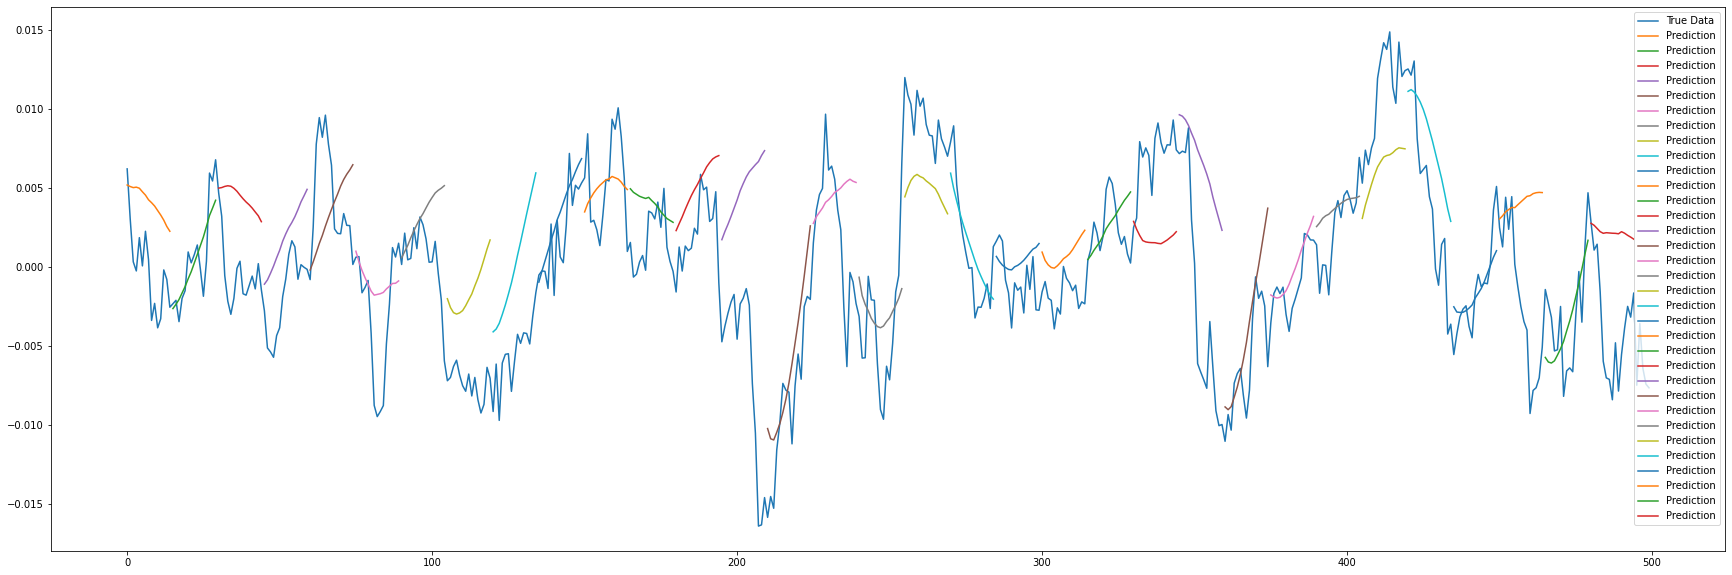

In [374]:
plt.rcParams["figure.figsize"] = [30,10]
plot_results_multiple(predictions, y_test,15)